In [1]:
import os
import pickle
import scipy.io as io

import sys

sys.path.append('..')

from tepfit.fit import ParamsJR, Model_fitting, RNNJANSEN, Costs, OutputNM

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import time
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter

sns.set()

In [10]:
# declare all the variables in one place
sc_file = '../data/Schaefer2018_200Parcels_7Networks_count.csv'         # 200x200 matrix
dist_file = '../data/Schaefer2018_200Parcels_7Networks_distance.csv'    # 200x200 matrix

file_labels = '../data/label_ts_corrected'                              # 200x2000 matrix

high_file = '../data/only_high_trial.mat'                               # 20x62x2000 matrix
file_leadfield = '../data/leadfield'                                    # 62x200 matrix
file_eeg = '../data/real_EEG'                                           # 62x2000 matrix
stim_weights_file = '../data/stim_weights.npy'                          # 200 vector

# open leadfield matrix file
lm = np.load(file_leadfield, allow_pickle=True)

# gm is the same shape as lm, gm = grand mean structural connectome from 400 HCP age=[21, 35]
gm = lm

# show the shape
print(gm.shape)

(62, 200)


In [15]:
np.load(file_labels, allow_pickle=True).shape

(200, 2000)

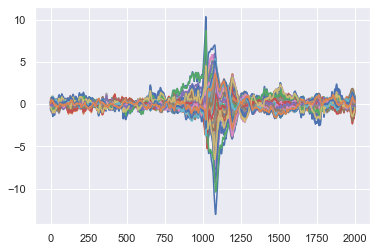

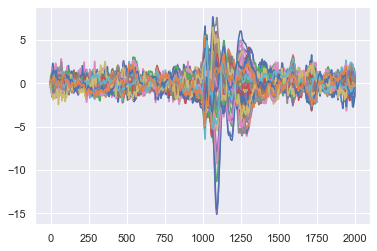

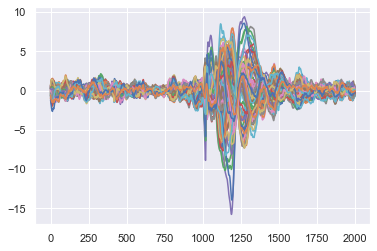

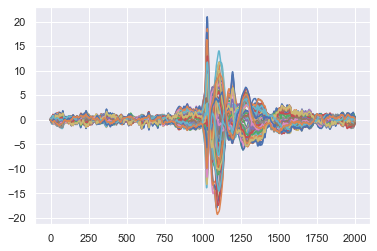

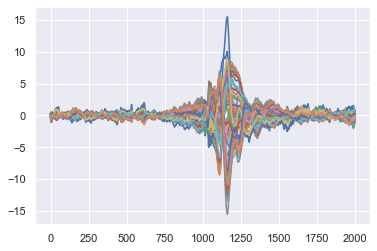

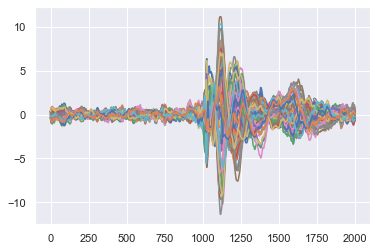

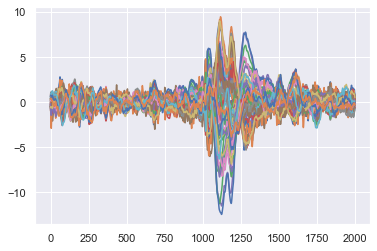

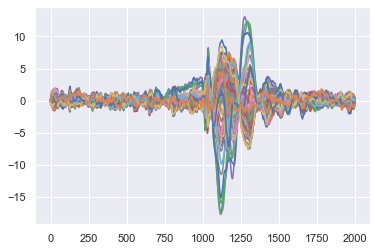

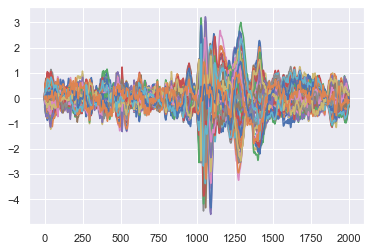

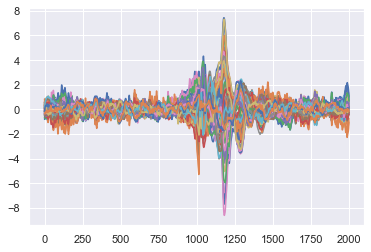

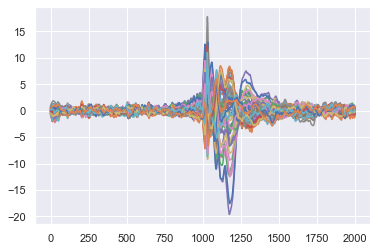

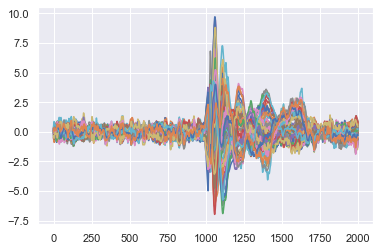

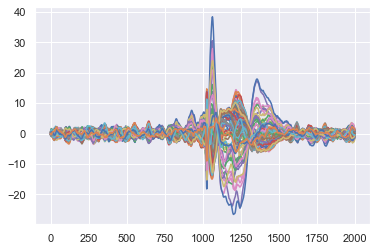

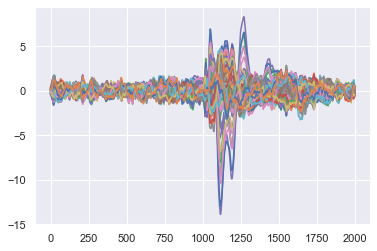

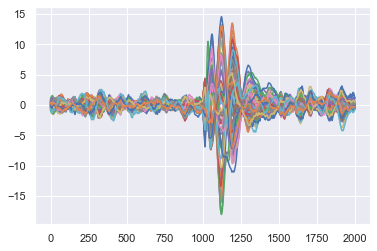

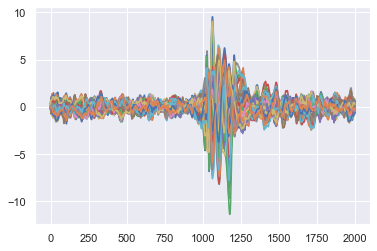

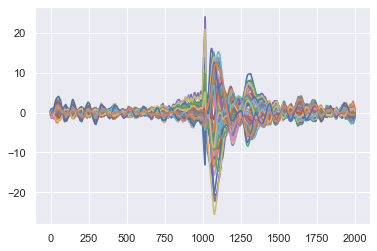

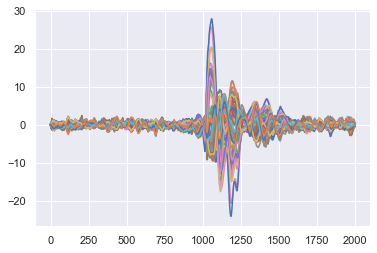

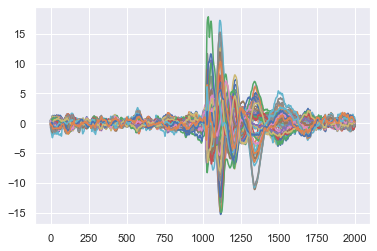

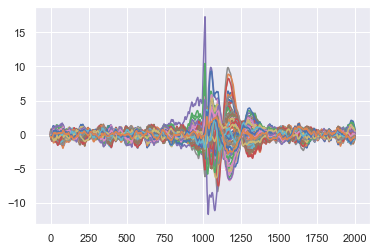

In [3]:
data = io.loadmat(high_file)['only_high_trial']

for idx in range(data.shape[0]):
    plt.plot(data[idx].T)
    plt.show()

In [4]:
print(data.shape)

(20, 62, 2000)


In [5]:
# open files
eeg = np.load(file_eeg, allow_pickle=True)
data_high = io.loadmat(high_file)
stim_weights = np.load(stim_weights_file)

sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
sc = 0.5 * (sc + sc.T)
sc =np.log1p(sc) / np.linalg.norm(np.log1p(sc))

dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values

ki0 = stim_weights[:, np.newaxis]

print('ki0 shape:', ki0.shape)
print(f'Leadfield min: {lm.min()}, max: {lm.max()}')
print('High trial shape:', data_high['only_high_trial'].shape)

ki0 shape: (200, 1)
Leadfield min: -125.8151626586914, max: 268.3122253417969
High trial shape: (20, 62, 2000)


In [8]:
dist_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,35.179443,56.133166,31.870022,59.885958,33.360635,72.961759,64.282866,84.817773,49.469207,...,241.141541,0.000000,0.000000,0.000000,199.402115,0.000000,0.000000,130.013821,149.869152,164.787625
1,35.179443,0.000000,29.918102,32.432830,34.343299,70.178557,30.861702,84.308343,54.654748,54.129590,...,208.026928,227.589157,0.000000,231.746862,246.687744,0.000000,0.000000,135.547466,143.773283,162.838052
2,56.133166,29.918102,0.000000,101.200042,27.972217,81.947104,115.118607,36.516195,74.125507,106.176391,...,0.000000,207.784424,0.000000,212.882746,220.576718,233.656708,207.537491,118.981886,125.385335,135.644879
3,31.870022,32.432830,101.200042,0.000000,73.636295,34.096920,34.586241,103.982184,84.779210,32.277521,...,0.000000,0.000000,0.000000,227.898460,0.000000,0.000000,0.000000,133.705294,159.996966,168.652805
4,59.885958,34.343299,27.972217,73.636295,0.000000,97.879943,33.297987,62.460928,28.886269,71.177899,...,0.000000,241.336136,225.683548,231.392181,0.000000,216.025146,0.000000,132.614776,149.149452,158.985058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000,0.000000,233.656708,0.000000,216.025146,0.000000,0.000000,191.080513,0.000000,0.000000,...,0.000000,179.457535,0.000000,77.737960,32.338411,0.000000,31.333155,0.000000,0.000000,155.361790
196,0.000000,0.000000,207.537491,0.000000,0.000000,0.000000,212.688126,193.348419,0.000000,0.000000,...,0.000000,0.000000,173.489670,82.849914,33.585426,31.333155,0.000000,138.646759,158.846008,136.405029
197,130.013821,135.547466,118.981886,133.705294,132.614776,142.466093,129.810389,115.939941,132.376467,101.512199,...,137.323510,115.665987,95.008453,133.187898,131.379548,0.000000,138.646759,0.000000,28.629030,56.633761
198,149.869152,143.773283,125.385335,159.996966,149.149452,118.984446,139.709333,111.157843,139.436262,128.352604,...,132.126791,113.839367,96.704575,129.150051,124.926259,0.000000,158.846008,28.629030,0.000000,28.401979


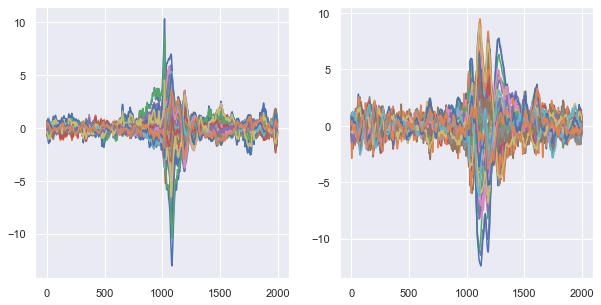

In [9]:
# visualize high trial 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(data_high['only_high_trial'][0].T)
ax[1].plot(data_high['only_high_trial'][6].T)
plt.show()

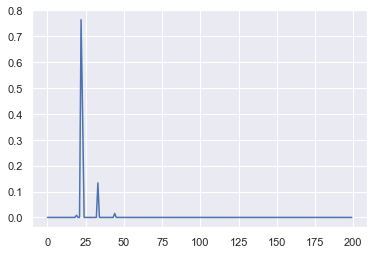

In [7]:
plt.plot(ki0)
plt.show()

In [8]:
# model specs
batch_size = 50            # the number of EEG signals to simulate
step_size = 0.0001         # how much to change on each iteration
input_size = 3             # the number of states with noise as input
num_epoches = 150          # how long to train the model for
state_size = 6             # the number of states in the JansenRit model
base_batch_num = 20

np.array([data_high['only_high_trial'][0]] * num_epoches).shape

(150, 62, 2000)

(4, 62, 2000)
epoch: 0 loss: -7985.0557
		Correlation coefficient: 0.25254568741486155 		cos_sim: 0.08020063991052571

400


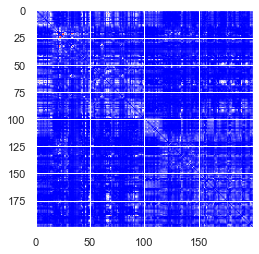

running time is  83.50073504447937 's


In [12]:
# start timing to see how long the model trains
start_time = time.time()

# the number of ROIs
node_size = stim_weights.shape[0]

# output should be a TS with 200 values to match empirical data (this would be used as Y-axis for some reason)
output_size = gm.shape[0]

# model specs
batch_size = 20            # the number of EEG signals to simulate
step_size = 0.0001         # how much to change on each iteration
input_size = 3             # the number of states with noise as input
num_epoches = 4          # how long to train the model for
state_size = 6             # the number of states in the JansenRit model
base_batch_num = 20

# integration step
tr = 0.001

# the output will match 62x200 dims
lm_v = np.zeros((output_size, node_size))

# create output path
output = '../leadfield_from_mne'

if not os.path.exists(output):
    os.mkdir(output)


########################################################
###                   START TRAINING                 ###
########################################################

# uncomment and change N if you want several subjects + use indentation
# N = 20
# for i in range(N):
i = 0   # if you uncomment, comment this one
data_mean = np.array([data_high['only_high_trial'][i]] * num_epoches)
print(data_mean.shape)

# create parameters for Jansen-Rit model 
par = ParamsJR('JR', A=[3.25, 0], a=[100, 0.5], B=[22, 0], b=[50, 1], g=[1000, 0.1],
               c1=[135, 0.2], c2=[135*0.8, 0.4], c3=[135*0.25, 0.8], c4=[135*0.25, 0.8],
               std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], y0=[2 * np.ones((output_size, 1)), 2 * np.ones((output_size, 1))], mu=[1., 2.5], k=[10, .3], cy0 = [5, 0], ki=[ki0, 0],
               lm=[lm, 1.0 * np.ones((output_size, node_size)) + lm_v],
               w_bb=[sc, 50 * np.ones((node_size, node_size))])

# create a Jansen-Rit model
model = RNNJANSEN(input_size, node_size, batch_size, step_size, output_size, tr, sc, lm, dist, 
                  fit_gains_flat=True, fit_lfm_flat=False, param=par)

# fit the model for 120 epochs, 
F = Model_fitting(model, data_mean[:,:,900:1300], num_epoches, cost=0)

# fit train data
u = np.zeros((node_size, 10, 400))   # 200x10x400 matrix
u[:, :, 110:120] = 1000
output_train = F.train(u=u)

u = np.zeros((node_size,10,400))
u[:,:,110:120]= 1000
X0 = np.random.uniform(0, 5, (node_size, state_size))
hE0 = np.random.uniform(0, 5, (node_size, 500))

output_test = F.test(X0, hE0, base_batch_num, u=u)

sc_mod = np.zeros((200,200))
mask = np.tril_indices(200,-1)


sc_mod[mask] = F.output_sim.weights[-10:,:].mean(0)
sc_mod = sc_mod+sc_mod.T
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.imshow(np.log1p(sc_mod), cmap = 'bwr')
plt.show()

end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

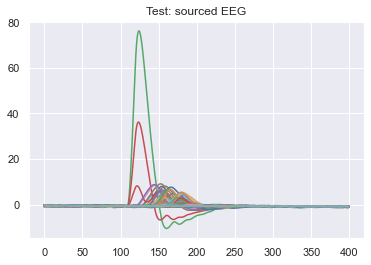

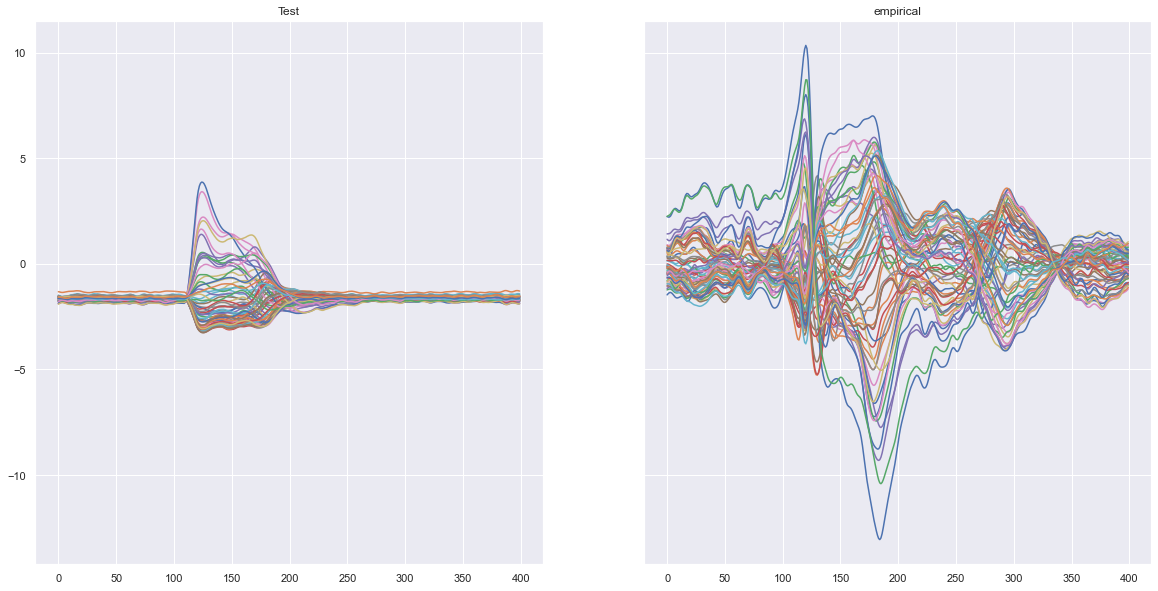

In [13]:
# save output
filename = '../data/sub_' + str(i) + '_fittingresults_stim_exp.pkl'
with open(filename, 'wb') as f:
    pickle.dump(F, f)

outfilename = '../data/sub_' + str(i) + '_simEEG_stim_exp.pkl'

with open(outfilename, 'wb') as f:
    pickle.dump(F.output_sim, f)

plt.plot((F.output_sim.E_test-F.output_sim.I_test).T)
plt.title('Test: sourced EEG')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax[0].plot(F.output_sim.eeg_test.T)
ax[0].set_title('Test')
ax[1].plot(data_high['only_high_trial'][i].T[900:1300,:])
ax[1].set_title('empirical')
plt.show()